# Importing All Necessary Packages, Libraries & Datasets

In [1]:
# import required packages for preparing data
import os
import re
import nltk
import pandas as pd
!pip install nlp
import nlp
import random

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

#packages for tensorflow
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#packages for plotting
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

#for plotting emotion frequency bar plot
from collections import Counter

#load emotion dataset & splitting training, testing and validation
from sklearn.model_selection import train_test_split
!pip install datasets==2.9.0
from datasets import load_dataset
dataset = load_dataset("emotion")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Preparing Data P0 (tweets as train, test, and validation)
### This is basically proof of concept for the model to be working, as good datasets are very difficult to find

In [2]:
data_train = dataset['train']
data_validate = dataset['validation']
data_test = dataset['test']

def extract_tweets_and_labels(data):
    tweets = [entry['text'] for entry in data]
    labels = [entry['label'] for entry in data]
    return tweets, labels

tweets_train, tweets_labels_train = extract_tweets_and_labels(data_train)
tweets_val, tweets_labels_val = extract_tweets_and_labels(data_validate)
tweets_test, tweets_labels_test = extract_tweets_and_labels(data_test)

tweets_labels_train = np.array(tweets_labels_train)
tweets_labels_val = np.array(tweets_labels_val)
tweets_labels_test = np.array(tweets_labels_test)

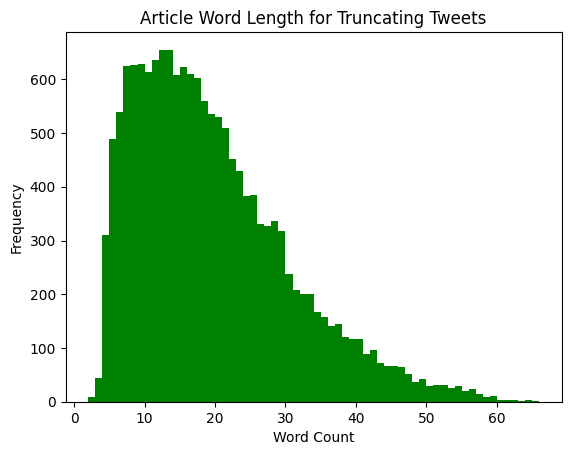

In [3]:
# Create a plot to see lengths of articles to truncate them for paddin test0
word_lengths = [len(sentence.split(' ')) for sentence in tweets_train]
num_bins = len(set(word_lengths))

import matplotlib.pyplot as plt
plt.title('Article Word Length for Truncating Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.hist(word_lengths, bins=num_bins, color = 'g')
plt.show()

In [4]:
#normally, you have to convert the labels to numbers, but this is already the case in this dataset so we can move forward
# Create a tokenizer with specified parameters
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

# Tokenize tweet training data
tokenizer.fit_on_texts(tweets_train)

# Tokenize tweet TESTING data
tokenizer.fit_on_texts(tweets_test)

# Tokenize validation data
tokenizer.fit_on_texts(tweets_val)

In [5]:
#set padding length for Model
maxlen = 50

#tokenize and pad training tweets
train_sequences = tokenizer.texts_to_sequences(tweets_train)
tweets_padded_train_seq = pad_sequences(train_sequences, truncating='post', padding='post', maxlen=maxlen)

#tokenize and pad validation tweets
val_sequences = tokenizer.texts_to_sequences(tweets_val)
tweets_padded_val_seq = pad_sequences(val_sequences, truncating='post', padding='post', maxlen=maxlen)

#tokenize and pad TEST tweets
tweets_test_sequences = tokenizer.texts_to_sequences(tweets_test)
tweets_padded_test_seq = pad_sequences(tweets_test_sequences, truncating='post', padding='post', maxlen=maxlen)

In [6]:
# Create a sequential model
model = tf.keras.models.Sequential([
    # Embedding layer with input length set to maxlen
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),

    # Bidirectional LSTM layer with return_sequences set to True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),

    # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),

    # Dense layer with softmax activation for classification
    tf.keras.layers.Dense(units=6, activation='softmax')
])

# Compile the model with sparse categorical crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
#train the model using the training data
tweets_model = model.fit(
    #padded sequences for the training data
    x=tweets_padded_train_seq,
    #corresponding labels for the training data
    y=tweets_labels_train,
    #validation data and labels for monitoring performance during training
    validation_data=(tweets_padded_val_seq, tweets_labels_val),
    #number of training epochs
    epochs=20,
    #callback for early stopping based on validation accuracy
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
500/500 [==============================] - 45s 55ms/step - loss: 1.3349 - accuracy: 0.4784 - val_loss: 0.8704 - val_accuracy: 0.6835
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.6164 - accuracy: 0.7789 - val_loss: 0.6207 - val_accuracy: 0.8005
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3557 - accuracy: 0.8786 - val_loss: 0.4822 - val_accuracy: 0.8445
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2278 - accuracy: 0.9267 - val_loss: 0.4419 - val_accuracy: 0.8665
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1778 - accuracy: 0.9452 - val_loss: 0.4067 - val_accuracy: 0.8780
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1373 - accuracy: 0.9571 - val_loss: 0.3751 - val_accuracy: 0.8810
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.1002 - accuracy: 0.9689 - val_loss: 0.3692 - val_accuracy: 0.886

In [8]:
#Obtain the tweets data into a list for plotting/observing
emotion_prob_test0 = []
predicted_emotion_test0 = []
#initiate a loop to store all of the data into a list, and then into a dataframe
i = 0
for i in range(len(tweets_labels_test)):
  #this takes the raw probabilities and obtains the most likely emotion given those probabilities
  p = model.predict(np.expand_dims(tweets_padded_test_seq[i], axis=0))[0]
  #this outputs the raw probabilities for each emotion given the text
  raw_probabilities_test0 = model.predict(np.expand_dims(tweets_padded_test_seq[i], axis=0))[0]
  predicted_class_test0 = np.argmax(p)
  emotion_prob_test0.append(raw_probabilities_test0.tolist())
  predicted_emotion_test0.append(predicted_class_test0)
  #sample only the first 20 values for sake of scrolling through code on github
  #can be changed to print all values, just delete the if statement
  if(i < 20):
    print('Tweet Content: ', tweets_test[i])
    print('Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise')
    print('Raw Probabilities:', raw_probabilities_test0)
    print('Predicted Emotion:', predicted_class_test0)
    print('Actual Emotion', tweets_labels_test[i])
  i = i + 1

1/1 [==============================] - 0s 23ms/step
Tweet Content:  im feeling rather rotten so im not very ambitious right now
Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise
Raw Probabilities: [9.9917823e-01 4.8553161e-04 3.1464695e-06 3.1920293e-04 1.1677360e-05
 2.2615195e-06]
Predicted Emotion: 0
Actual Emotion 0
1/1 [==============================] - 0s 20ms/step
Tweet Content:  im updating my blog because i feel shitty
Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise
Raw Probabilities: [9.9915385e-01 5.6766445e-04 2.8757586e-06 2.6125368e-04 1.2232522e-05
 2.0730367e-06]
Predicted Emotion: 0
Actual Emotion 0
1/1 [==============================] - 0s 20ms/step
Tweet Content:  i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise
Raw Probabilities: [9.9931943e-01 1.3374665e-04 4.434221

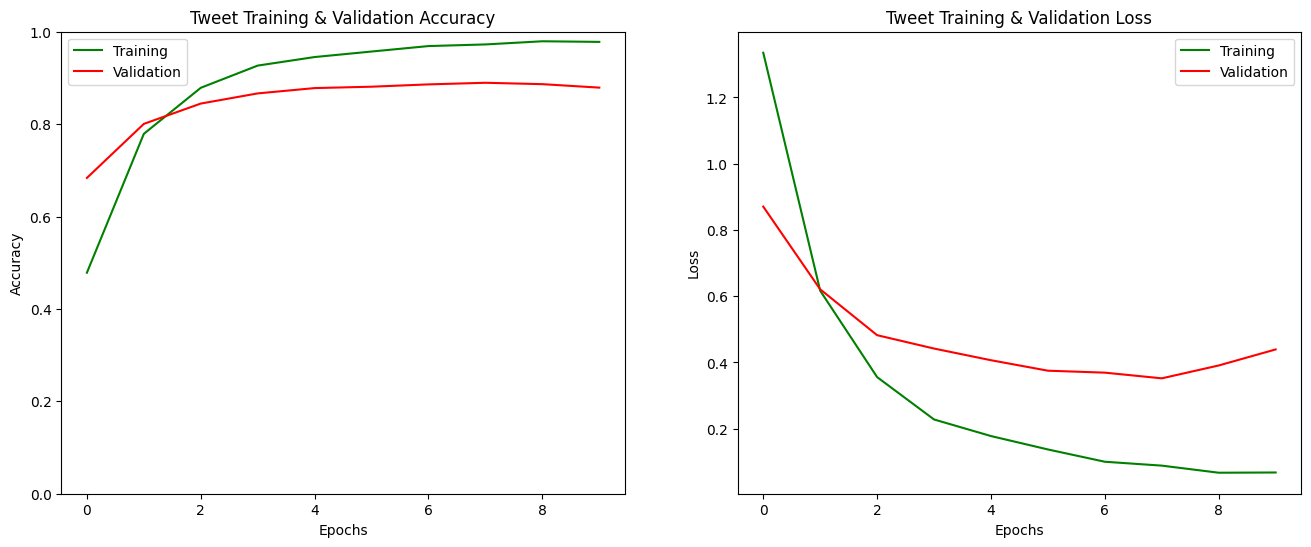

In [9]:
#Training & Validation set Plots

def plot_training_results(history, title0, title1):
    #get the number of training epochs
    epochs = len(history.history['loss'])

    #create a 1x2 subplot grid with a specified size
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    #plot accuracy
    axs[0].plot(np.arange(epochs), history.history['accuracy'], label='Training', color='g')  #plot training accuracy
    axs[0].plot(np.arange(epochs), history.history['val_accuracy'], label='Validation', color='r')  #plot validation accuracy
    axs[0].set_ylim([0., 1.])  #set y-axis limits
    axs[0].set_xlabel('Epochs')  #set x-axis label
    axs[0].set_ylabel('Accuracy')  #set y-axis label
    axs[0].legend()  #display legend
    axs[0].set_title(title0)
    #plot loss
    axs[1].plot(np.arange(epochs), history.history['loss'], label='Training', color='g')  #plot training loss
    axs[1].plot(np.arange(epochs), history.history['val_loss'], label='Validation', color='r')  #plot validation loss
    axs[1].set_xlabel('Epochs')  #set x-axis label
    axs[1].set_ylabel('Loss')  #set y-axis label
    axs[1].legend()  #display legend
    axs[1].set_title(title1)
    #plt title

    #display the plots
    plt.show()

plot_training_results(tweets_model, 'Tweet Training & Validation Accuracy', "Tweet Training & Validation Loss")

In [10]:
#test model on testing data
TweetTestingModel = model.evaluate(x=tweets_padded_test_seq, y=tweets_labels_test)

63/63 [==============================] - 0s 7ms/step - loss: 0.4843 - accuracy: 0.8710


<Figure size 800x800 with 0 Axes>

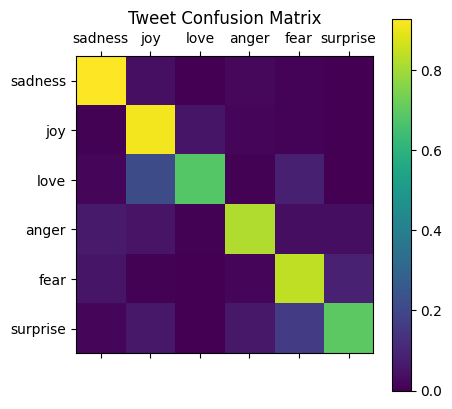

In [11]:
#confusion matrix plotting
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def display_confusion_matrix(true_labels, predicted_labels, class_names, title):
    #compute and normalize the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

    #create a figure with a specified size
    plt.figure(figsize=(8, 8))

    #display the confusion matrix as a matrix plot
    plt.matshow(cm)

    #set x-axis and y-axis tick positions and labels
    plt.xticks(np.arange(len(class_names)), labels=class_names)
    plt.yticks(np.arange(len(class_names)), labels=class_names)

    #display a colorbar to indicate the scale
    plt.colorbar()
    #title
    plt.title(title)
    plt.show()


display_confusion_matrix(tweets_labels_test, predicted_emotion_test0, class_names, "Tweet Confusion Matrix")

In [12]:
#possibly for extracting emotion scores

# Preparing Data P1 (tweets as train set & tribune article headlines as test set)

In [14]:
dataframe = pd.read_csv('tribune.csv')
dataframe = dataframe.dropna()

#results dicitonary is a list for the NLTK scores
results = {}

#blobRes dictionary is a list for blobText scores
blobRes = {}

#texts dictionary is a list for the content of the articles to be cleaned
texts = {}

#new list for holding emotion content of each article
article_test_labels = []

#heads is a dictionary for the content of the headings to be cleaned
heads = {}
headsList = [] #list for the ML portion of heading analyzing
sent = SentimentIntensityAnalyzer()

#loop to extract article content/heading and clean for each article
for i, row in tqdm(dataframe.iterrows(), total = len(dataframe)):
    #assign row variables
    text = row['article']
    Id = row['Index']
    heading = row['headline']
    emotion = row['emotion']

    #normalize text (lowercase)
    text = text.lower()

    #split text for cleaning
    split_text = text.split()

    #remove all ampersans(&) and replace with "and"
    andText = [word.replace("a&m","a and m") for word in split_text]

    #cleans text for all things not alphabetical
    alphatext = [word for word in andText if word.isalpha()]

    #get stopwords from NLTK stopwords package
    NLTKstopwords = set(stopwords.words('english'))

    #clean text by saying that if the word is not in nltk stopwords list,
    #then add that word to the cleantext list
    cleantext = [word for word in alphatext if word not in NLTKstopwords]

    #lemmatize text
    wl = WordNetLemmatizer()
    lemText = [wl.lemmatize(y) for y in cleantext]

    #this takes the lemText list and makes it a string
    blobtext = ' '.join(lemText)

    #for each article, take the polarity scores
    results[Id] = sent.polarity_scores(blobtext)
    texts[Id] = blobtext

    #append emotion labels for comparison
    article_test_labels.append(emotion)

    #now clean the headings for James
    heading = heading.lower()

    #split into list of words
    split_heading = heading.split()

    #clean headings for all things not alphabetical
    alphahead = [word for word in split_heading if word.isalpha()]

    #remove stopwords from the alphabetical words
    cleanhead = [word for word in alphahead if word not in NLTKstopwords]

    #join the list cleanhead into a single string to be analyed
    blobhead = ' '.join(cleanhead)

    #put into a list of cleaned strings for each header
    heads[Id] = blobhead
    headsList.append(blobhead)
    #put into a list of cleaned content for each article

    #obtain list of each TextBlob sentiment/subjectivity score from the blobtext variable
    blobRes[Id] = (TextBlob(blobtext).sentiment)

  0%|          | 0/63 [00:00<?, ?it/s]

In [15]:
#obtain datadrame from results list using pandas
NLTK = pd.DataFrame(results).T

#reset the dataframe index and change column name to Id
NLTK = NLTK.reset_index(drop = True)

#combine the results data witht the original csv dataframe
vaders = pd.concat([dataframe, NLTK], axis = 1, join = 'outer')

#create dataframe using list of TextBlob scores
BlobFrame = pd.DataFrame(blobRes).T

#re-lable columns for better readability
BlobFrame.columns = ['Sentiment', 'Subjectivity']

#reset blobframe index so that when concated, they line up
BlobFrame = BlobFrame.reset_index(drop = True)

#combine the updated csv (from the last line of code) to the textblob scores dataframe
vaderBlob = pd.concat([vaders, BlobFrame], axis = 1, join = 'outer')

#initialize k
k = 1

#replace the heading with cleaned heading using a loop
for i, row in tqdm(vaders.iterrows(), total = len(vaders)):
    heading = row['headline']
    text = row['article']

    #set the headings to be replaced to the list of head at position k
    headreplace = heads[k]
    textreplace = texts[k]

    #replace the headings and update the vaderBlob dataframe by setting it equal to the new replaced dataframe
    vaderBlob = vaderBlob.replace(heading, headreplace)
    vaderBlob = vaderBlob.replace(text, textreplace)

    #move index forward 1
    k = k + 1

  0%|          | 0/63 [00:00<?, ?it/s]

In [16]:
#save this updated csv to a new file
vaderBlob.to_csv("C:\\Users\\tyler\\NLP News Analytics\\tribune_new.csv")

In [17]:
#converts texts into list for use for Model testing data
def values_to_list(input_dict):
    return list(input_dict.values())

article_content_test = values_to_list(texts)

# Model P1

### Trained on tweets, tested on tribune article headings

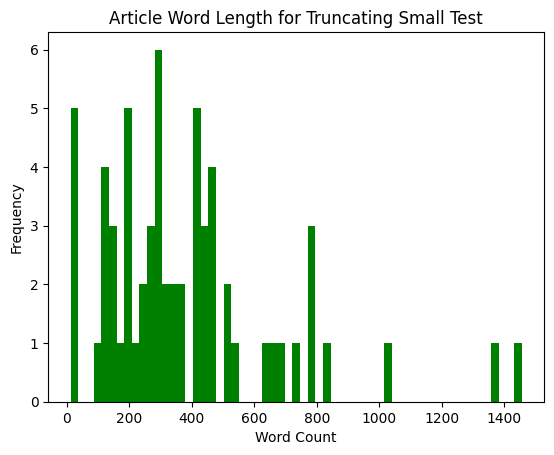

In [18]:
#Re-use tweet train data, but obtain new testing data from my own CSVs
# Create a plot to see lengths of articles to truncate them for paddin tribune article test
word_lengths = [len(sentence.split(' ')) for sentence in article_content_test]
num_bins = len(set(word_lengths))

import matplotlib.pyplot as plt
plt.title('Article Word Length for Truncating Small Test')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.hist(word_lengths, bins=num_bins, color = 'g')
plt.show()

In [19]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
# Tokenize my tribune article data
tokenizer.fit_on_texts(article_content_test)

#pad my tribune article headings
maxlen = 500
test_sequences = tokenizer.texts_to_sequences(article_content_test)
article_padded_test_seq = pad_sequences(test_sequences, truncating='post', padding='post', maxlen=maxlen)

#Map predicted emotions to their corresponding numerical value
# Create a dictionary mapping classes to indices
class_to_index_mapping = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

# Create a dictionary mapping indices to classes
index_to_class_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Lambda function to convert class names to corresponding indices
convert_names_to_ids = lambda labels: np.array([class_to_index_mapping.get(label) for label in labels])

article_test_labels_converted = convert_names_to_ids(article_test_labels)

#convert list to a np.array for Model
article_test_labels_converted = np.array(article_test_labels_converted)

In [20]:
#This model is trained the same way as the tweets, just tested with different data.
#Therefore, the model creating and fitting will be skipped

In [21]:
ArticleTesting = model.evaluate(x=article_padded_test_seq, y=article_test_labels_converted)

2/2 [==============================] - 1s 51ms/step - loss: 5.4479 - accuracy: 0.1429


In [22]:
emotion_prob_test0 = []
predicted_emotion_test0 = []
#initiate a loop to store all of the data into a list, and then into a dataframe
i = 0
for i in range(len(tweets_labels_test[:60])):
  #this takes the raw probabilities and obtains the most likely emotion given those probabilities
  p = model.predict(np.expand_dims(tweets_padded_test_seq[i], axis=0))[0]
  #this outputs the raw probabilities for each emotion given the text
  raw_probabilities_test0 = model.predict(np.expand_dims(tweets_padded_test_seq[i], axis=0))[0]
  predicted_class_test0 = np.argmax(p)
  emotion_prob_test0.append(raw_probabilities_test0.tolist())
  predicted_emotion_test0.append(predicted_class_test0)
  i = i + 1
  print('Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise')
  print('Raw Probabilities:', raw_probabilities_test0)
  print('Predicted Emotion:', predicted_class_test0)

1/1 [==============================] - 0s 22ms/step
Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise
Raw Probabilities: [9.9917823e-01 4.8553161e-04 3.1464695e-06 3.1920293e-04 1.1677360e-05
 2.2615195e-06]
Predicted Emotion: 0
1/1 [==============================] - 0s 20ms/step
Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise
Raw Probabilities: [9.9915385e-01 5.6766445e-04 2.8757586e-06 2.6125368e-04 1.2232522e-05
 2.0730367e-06]
Predicted Emotion: 0
1/1 [==============================] - 0s 35ms/step
Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise
Raw Probabilities: [9.9931943e-01 1.3374665e-04 4.4342219e-06 5.0475000e-04 3.4954344e-05
 2.7367162e-06]
Predicted Emotion: 0
1/1 [==============================] - 0s 37ms/step
Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise
Raw Probabilities: [1.2092190e-04 9.9924505e-01 3.9035387e-04 1.7378329e-04

In [23]:
#TODO: Save back into CSV


In [24]:
#TODO: Visualization plot

# Preparing Data P2 (larger article set, fully split into training, testing, and validation

In [25]:
dataframe2 = pd.read_csv('LargeArticleDataset.csv')

In [26]:
#results dicitonary is a list for the NLTK scores
results2 = {}

#blobRes dictionary is a list for blobText scores
blobRes2 = {}

#texts dictionary is a list for the content of the articles to be cleaned
texts2 = {}

#new list for holding the emotion content of each article
large_article_labels_full = []

#heads is a dictionary for the content of the headings to be cleaned
heads2 = {}
sent2 = SentimentIntensityAnalyzer()

#loop to extract article content/heading and clean for each article
for i, row in tqdm(dataframe2.iterrows(), total = len(dataframe2)):
    #assign row variables
    text2 = row['article']
    Id2 = row['Index']
    heading2 = row['headline']
    emotion2 = row['emotion']

    #normalize text (lowercase)
    text2 = text2.lower()

    #split text for cleaning
    split_text2 = text2.split()

    #remove all ampersans(&) and replace with "and"
    andText2 = [word.replace("a&m","a and m") for word in split_text2]

    #cleans text for all things not alphabetical
    alphatext2 = [word for word in andText2 if word.isalpha()]

    #get stopwords from NLTK stopwords package
    NLTKstopwords2 = set(stopwords.words('english'))

    #clean text by saying that if the word is not in nltk stopwords list,
    #then add that word to the cleantext list
    cleantext2 = [word for word in alphatext2 if word not in NLTKstopwords2]

    #lemmatize text
    wl2 = WordNetLemmatizer()
    lemText2 = [wl2.lemmatize(y) for y in cleantext2]

    #this takes the lemText list and makes it a string
    blobtext2 = ' '.join(lemText2)

    #for each article, take the polarity scores
    results2[Id2] = sent2.polarity_scores(blobtext2)
    texts2[Id2] = blobtext2

    #append emotion labels for comparison
    large_article_labels_full.append(emotion2)

    #now clean the headings for James
    heading2 = heading2.lower()

    #split into list of words
    split_heading2 = heading2.split()

    #clean headings for all things not alphabetical
    alphahead2 = [word for word in split_heading2 if word.isalpha()]

    #remove stopwords from the alphabetical words
    cleanhead2 = [word for word in alphahead2 if word not in NLTKstopwords2]

    #join the list cleanhead into a single string to be analyed
    blobhead2 = ' '.join(cleanhead2)

    #put into a list of cleaned strings for each header
    heads2[Id2] = blobhead2

    #put into a list of cleaned content for each article

    #obtain list of each TextBlob sentiment/subjectivity score from the blobtext variable
    blobRes2[Id2] = (TextBlob(blobtext2).sentiment)

  0%|          | 0/2225 [00:00<?, ?it/s]

In [27]:
#obtain dataframe from results list using pandas
NLTK2 = pd.DataFrame(results2).T

#reset the dataframe index and change column name to Id
NLTK2 = NLTK2.reset_index(drop = True)

#combine the results data witht the original csv dataframe
vaders2 = pd.concat([dataframe2, NLTK2], axis = 1, join = 'outer')

#create dataframe using list of TextBlob scores
BlobFrame2 = pd.DataFrame(blobRes2).T

#re-lable columns for better readability
BlobFrame2.columns = ['Sentiment', 'Subjectivity']

#reset blobframe index so that when concated, they line up
BlobFrame2 = BlobFrame2.reset_index(drop = True)

#combine the updated csv (from the last line of code) to the textblob scores dataframe
vaderBlob2 = pd.concat([vaders2, BlobFrame2], axis = 1, join = 'outer')

#initialize k
k = 0

#replace the heading with cleaned heading using a loop
for i, row in tqdm(vaders2.iterrows(), total = len(vaders2)):
    heading2 = row['headline']
    text2 = row['article']

    #set the headings to be replaced to the list of head at position k
    headreplace2 = heads2[k]
    textreplace2 = texts2[k]

    #replace the headings and update the vaderBlob dataframe by setting it equal to the new replaced dataframe
    vaderBlob2 = vaderBlob2.replace(heading2, headreplace2)
    vaderBlob2 = vaderBlob2.replace(text2, textreplace2)

    #move index forward 1
    k = k + 1

#save this updated csv to a new file
vaderBlob2.to_csv("C:\\Users\\tyler\\NLP News Analytics\\LargeArticleDataset_new.csv")

  0%|          | 0/2225 [00:00<?, ?it/s]

In [28]:
#converts texts2 into list for use
def values_to_list(input_dict):
    return list(input_dict.values())

large_article_content = values_to_list(texts2)

convert_names_to_ids = lambda labels: np.array([class_to_index_mapping.get(label) for label in labels])

#convert label names into Ids using previous function
large_article_labels = convert_names_to_ids(large_article_labels_full)

# Model P2 (large dataset)

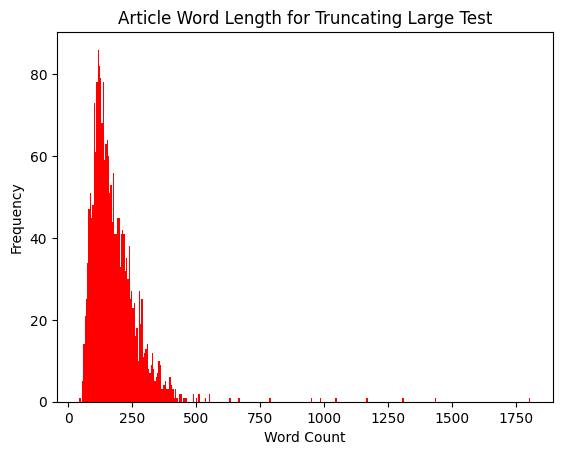

In [29]:
#Re-use tweet train data, but obtain new testing data from my own CSVs
# Create a plot to see lengths of articles to truncate them for paddin tribune article test
word_lengths = [len(sentence.split(' ')) for sentence in large_article_content]
num_bins = len(set(word_lengths))

import matplotlib.pyplot as plt
plt.title('Article Word Length for Truncating Large Test')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.hist(word_lengths, bins=num_bins, color = 'r')
plt.show()

In [31]:
df = pd.read_csv("LargeArticleDataset_new.csv")
# Set the proportions for training, validation, and testing sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the number of rows for each set
total_rows = len(df)
train_size = int(total_rows * train_ratio)
val_size = int(total_rows * val_ratio)
test_size = total_rows - train_size - val_size

# Extract the rows for each set
train_data = df.iloc[:train_size, :]
val_data = df.iloc[train_size:(train_size + val_size), :]
test_data = df.iloc[(train_size + val_size):, :]

# Store the indices of the testing set
test_indices = test_data.index.tolist()

# Reset indices of train and validation sets if needed
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Perform your training, validation, and testing operations here
# this is where you split the train,val,and test sets into their x and y values into a list
# need 3 different loops to extract data from each set so that we can recover them later

# Loop1: Train Data Loop
large_train_content = []
large_train_labels = []
for i, row in tqdm(train_data.iterrows(), total = len(train_data)):
    trainLabel = row['emotion']
    trainContent = row['article']
    large_train_content.append(trainContent)
    large_train_labels.append(trainLabel)

# Loop2: Validation Data Loop
large_val_content = []
large_val_labels = []
for i, row in tqdm(val_data.iterrows(), total = len(val_data)):
    valLabel = row['emotion']
    valContent = row['article']
    large_val_content.append(valContent)
    large_val_labels.append(valLabel)

# Loop3: Test Data Loop
large_test_content = []
large_test_labels = []
for i, row in tqdm(test_data.iterrows(), total = len(test_data)):
    testLabel = row['emotion']
    testContent = row['article']
    large_test_content.append(testContent)
    large_test_labels.append(testLabel)

'''#convert to arrays for use with ML model
large_train_content = np.array(large_train_content)
large_val_content = np.array(large_val_content)
large_test_content = np.array(large_test_content)'''

#Map predicted emotions to their corresponding numerical value
# Create a dictionary mapping classes to indices
class_to_index_mapping = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

# Create a dictionary mapping indices to classes
index_to_class_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Lambda function to convert class names to corresponding indices
convert_names_to_ids = lambda labels: np.array([class_to_index_mapping.get(label) for label in labels])

#convert all large set labels from emotion to numeric
large_train_labels_numeric = convert_names_to_ids(large_train_labels)
large_val_labels_numeric = convert_names_to_ids(large_val_labels)
large_test_labels_numeric = convert_names_to_ids(large_test_labels)

  0%|          | 0/1335 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

In [32]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

#re-define max length
maxlen = 350

# Tokenize my large training data
tokenizer.fit_on_texts(large_train_content)

# Tokenize my large validation data
tokenizer.fit_on_texts(large_val_content)

# Tokenize my large test data
tokenizer.fit_on_texts(large_test_content)

#tokenize and pad my LARGE TRAINING data
train_sequences_large = tokenizer.texts_to_sequences(large_train_content)
padded_train_seq_large = pad_sequences(train_sequences_large, truncating='post', padding='post', maxlen=maxlen)

#tokenize and pad my LARGE VALIDATION data
val_sequences_large = tokenizer.texts_to_sequences(large_val_content)
padded_val_seq_large = pad_sequences(val_sequences_large, truncating='post', padding='post', maxlen=maxlen)

#tokenize and pad my LARGE TEST data
test_sequences_large = tokenizer.texts_to_sequences(large_test_content)
padded_test_seq_large = pad_sequences(test_sequences_large, truncating='post', padding='post', maxlen=maxlen)

In [33]:
# Create a sequential model for large dataset | 2 models so that we can fine tune this one
large_article_model = tf.keras.models.Sequential([
    # Embedding layer with input length set to maxlen
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),

    # Bidirectional LSTM layer with return_sequences set to True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),

    # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),

    # Dense layer with softmax activation for classification
    tf.keras.layers.Dense(units=6, activation='softmax'),

    #Dropout layers (deactivates some neurons during training, preventing over-reliance on pathways)
    tf.keras.layers.Dropout(0.3)

])

# Compile the model with sparse categorical crossentropy loss, Adam optimizer, and accuracy metric
large_article_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display a summary of the model architecture
large_article_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 350, 16)           160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 350, 40)           5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175

In [34]:
#train the model using the large training data
large_model = large_article_model.fit(
    #padded sequences for the training data
    x=padded_train_seq_large,
    #corresponding labels for the training data
    y=large_train_labels_numeric,
    #validation data and labels for monitoring performance during training
    validation_data=(padded_val_seq_large, large_val_labels_numeric),
    #number of training epochs
    epochs=100,
    #callback for early stopping based on validation accuracy
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
)

Epoch 1/100
42/42 [==============================] - 21s 278ms/step - loss: 5.6905 - accuracy: 0.3633 - val_loss: 2.7415 - val_accuracy: 0.3708
Epoch 2/100
42/42 [==============================] - 9s 211ms/step - loss: 5.3178 - accuracy: 0.3858 - val_loss: 2.0475 - val_accuracy: 0.3708
Epoch 3/100
42/42 [==============================] - 8s 184ms/step - loss: 5.5366 - accuracy: 0.3963 - val_loss: 2.6184 - val_accuracy: 0.3708
Epoch 4/100
42/42 [==============================] - 9s 207ms/step - loss: 5.2471 - accuracy: 0.4007 - val_loss: 2.2686 - val_accuracy: 0.3708
Epoch 5/100
42/42 [==============================] - 5s 128ms/step - loss: 5.3469 - accuracy: 0.3708 - val_loss: 2.0057 - val_accuracy: 0.3708
Epoch 6/100
42/42 [==============================] - 10s 232ms/step - loss: 5.1827 - accuracy: 0.3700 - val_loss: 2.3914 - val_accuracy: 0.3708


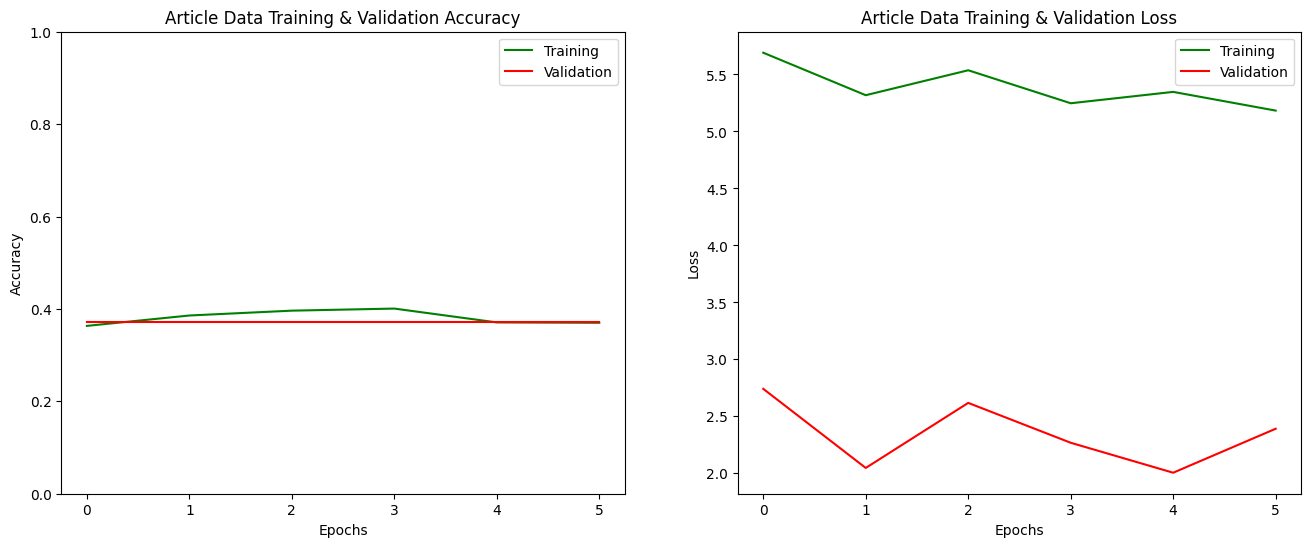

In [35]:
plot_training_results(large_model, 'Article Data Training & Validation Accuracy', 'Article Data Training & Validation Loss')

In [36]:
# Test now trained model on my large dataset
large_model_test = large_article_model.evaluate(padded_test_seq_large, y=large_test_labels_numeric)

14/14 [==============================] - 0s 26ms/step - loss: 1.5103 - accuracy: 0.6382


In [37]:
large_emotion_prob = []
large_predicted_emotion = []
#initiate a loop to store all of the test_data into a list, and then into a dataframe
i = 0
for i in range(len(padded_test_seq_large)):
  #this takes the raw probabilities and obtains the most likely emotion given those probabilities
  p2 = large_article_model.predict(np.expand_dims(padded_test_seq_large[i], axis=0))[0]
  #this outputs the raw probabilities for each emotion given the text
  large_raw_probabilities = large_article_model.predict(np.expand_dims(padded_test_seq_large[i], axis=0))[0]
  large_predicted_class = np.argmax(p2)
  large_emotion_prob.append(large_raw_probabilities.tolist())
  large_predicted_emotion.append(large_predicted_class)
  #sample only the first 20 values for sake of scrolling through code on github
  #can be changed to print all values, just delete the if statement
  if(i < 20):
    print('Article Content: ', large_train_content[i])
    print('Corresponding Emotions: 0: sadness, 1: joy, 2: love, 3: anger, 4: fear, 5: surprise')
    print('Raw Probabilities:', large_raw_probabilities)
    print('Predicted Emotion:', large_predicted_class)
    print('Actual Emotion:', large_train_labels_numeric[i])
  i = i + 1

1/1 [==============================] - 0s 31ms/step
Article Content:  musician tackle red tape musician group tackle visa regulation blamed hindering british act chance succeeding atlantic singer hoping perform expect pay simply obtaining visa group including musician union calling raw faced british performer act faced comparable expense bureaucracy visiting promotional purpose nigel mccune musician union british musician disadvantaged compared counterpart sponsor petition behalf form amounting nearly page musician face tougher regulation athlete journalist mistake form risk ban ability career say mr mccune biggest music market mean creaky bureaucracy say mr mccune current situation preventing british act maintaining momentum developing added musician union stance endorsed music manager forum mmf british artist face uphill struggle succeed thanks tough visa requirement seen impractical mmf secretary james seller imagine orchestra orkneys member travel london visa processed market seen 

<Figure size 800x800 with 0 Axes>

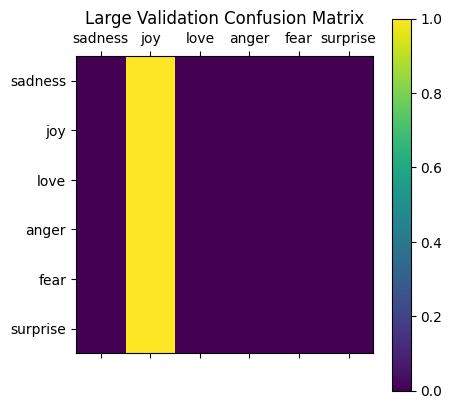

In [38]:
display_confusion_matrix(large_test_labels_numeric, large_predicted_emotion, class_names, "Large Validation Confusion Matrix")

In [39]:
#convert the numeric values in predicted emotion
large_numeric_to_emotion = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# declare index to class function for converting numerical emotion values to their corresponding

# Convert emotion_prob list to a DataFrame
emotion_prob_df2 = pd.DataFrame(large_emotion_prob, columns=index_to_class_mapping.values())

#rename columns to match english
emotion_prob_df2.columns = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

# Add the predicted_emotion list as a new column
emotion_prob_df2['PredictedEmotion'] = large_predicted_emotion

#change the numeric values on dataframe to representative emotions in english
emotion_prob_df2['PredictedEmotion'] = emotion_prob_df2['PredictedEmotion'].map(large_numeric_to_emotion)

# Display the resulting DataFrame
print(emotion_prob_df2)

vaderBlob2_truncated = vaderBlob2.head(445)
Large_Dataframe = pd.concat([vaderBlob2_truncated, emotion_prob_df2], axis = 1, join = 'outer')

Large_Dataframe.to_csv('C:\\Users\\tyler\\NLP News Analytics\\Large_Set_Tested.csv', index = False)
print(Large_Dataframe)

      Sadness       Joy      Love     Anger      Fear  Surprise  \
0    0.095207  0.773093  0.042538  0.013510  0.042137  0.033515   
1    0.002813  0.993617  0.001702  0.000148  0.000768  0.000952   
2    0.012525  0.969150  0.008360  0.001226  0.004261  0.004477   
3    0.012639  0.968898  0.008158  0.001282  0.004507  0.004515   
4    0.183425  0.527321  0.071456  0.046947  0.113597  0.057253   
..        ...       ...       ...       ...       ...       ...   
440  0.121548  0.690772  0.079300  0.019714  0.050117  0.038550   
441  0.141615  0.673540  0.050112  0.023210  0.064636  0.046886   
442  0.004129  0.990570  0.002470  0.000258  0.001192  0.001380   
443  0.004209  0.990401  0.002490  0.000272  0.001238  0.001389   
444  0.003389  0.992308  0.002023  0.000194  0.000951  0.001135   

    PredictedEmotion  
0                joy  
1                joy  
2                joy  
3                joy  
4                joy  
..               ...  
440              joy  
441        

# Model P3 - Subjectivity Model

In [40]:
dataframe3 = pd.read_csv("LargeArticleDataset_new.csv")
dataframe3

,Unnamed: 0,Index,article,headline,emotion,neg,neu,pos,compound,Sentiment,Subjectivity
0,0,0,musician tackle red tape musician group tackle...,entertainment,sadness,0.131,0.712,0.157,0.7351,0.045892,0.265726
1,1,1,desire number prestigious grammy award hit ver...,entertainment,joy,0.117,0.666,0.217,0.9854,0.095050,0.475694
2,2,2,rocker doherty stage fight rock singer pete do...,entertainment,joy,0.172,0.682,0.146,-0.7964,0.066071,0.242651
3,3,3,snicket top box office chart film adaptation l...,entertainment,sadness,0.133,0.696,0.171,-0.1280,-0.050000,0.820000
4,4,4,ocean raid box office ocean crime caper sequel...,entertainment,joy,0.075,0.738,0.186,0.9413,0.071667,0.420000
...,...,...,...,...,...,...,...,...,...,...,...
2220,2220,2220,norway upholds napster ruling norwegian studen...,tech,joy,0.102,0.764,0.134,0.7650,0.061224,0.315193
2221,2221,2221,warning window word file writing microsoft wor...,tech,love,0.120,0.760,0.120,-0.4718,-0.086406,0.556322
2222,2222,2222,fast lift record book high speed lift world ta...,tech,surprise,0.040,0.882,0.078,0.8519,0.140980,0.469804
2223,2223,2223,nintendo add medium playing nintendo releasing...,tech,joy,0.000,0.828,0.172,0.9665,0.011719,0.461719


In [41]:
Subjectivity_Scores = []
Sentiment_Scores= []
for i, row in tqdm(dataframe3.iterrows(), total = len(dataframe3)):
    #assign row variables
    subjectivity = row["Subjectivity"]
    sentiment = row["Sentiment"]
    #append scores to list
    Subjectivity_Scores.append(subjectivity)
    Sentiment_Scores.append(sentiment)
i = 0

#define function to group scores into 4 categories for model
def categorize_sentiment(score):
    if score < 0.25:
        return "Objective"
    elif score < 0.5:
        return "Slightly_Objective"
    elif score < 0.75:
        return "Slightly_Subjective"
    else:
        return "Subjective"

#new list for Grouped scores
Grouped_Scores = []

for i in range(len(Subjectivity_Scores)):
    category = categorize_sentiment(Subjectivity_Scores[i])
    Grouped_Scores.append(category)
    i = i + 1

#Map predicted emotions to their corresponding numerical value
# Create a dictionary mapping classes to indices
category_to_index_mapping = {
    "Objective": 0,
    "Slightly_Objective": 1,
    "Slightly_Subjective": 2,
    "Subjective": 3
}

# Create a dictionary mapping indices to categories
index_to_category_mapping = {
    0: 'Objective',
    1: 'Slightly_Objective',
    2: 'Slightly_Subjective',
    3: 'Subjective'
}

# Lambda function to convert class names to corresponding indices
categories_to_ids = lambda labels: np.array([category_to_index_mapping.get(label) for label in labels])

#convert categories into corresponding numbers
Grouped_Scores_Numbers = categories_to_ids(Grouped_Scores)

#set the proportions for training, validation, and testing sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

#calculate the number of rows for each set
total_rows = len(df)
train_size = int(total_rows * train_ratio)
val_size = int(total_rows * val_ratio)
test_size = total_rows - train_size - val_size

grouped_train_labels = Grouped_Scores_Numbers[:train_size]
grouped_val_labels = Grouped_Scores_Numbers[train_size: train_size + val_size]
grouped_test_labels = Grouped_Scores_Numbers[train_size + val_size:]

  0%|          | 0/2225 [00:00<?, ?it/s]

In [42]:
print(len(large_test_content))
print(len(large_train_content))
print(len(large_val_content))

445
1335
445


In [43]:
#re-define max length
maxlen = 350

#we already have the framework for the large model, so we can simply use it here again
large_article_model_categories = tf.keras.models.Sequential([
    # Embedding layer with input length set to maxlen
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),

    # Bidirectional LSTM layer with return_sequences set to True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),

    # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),

    # Dense layer with softmax activation for classification
    tf.keras.layers.Dense(units=4, activation='softmax'),

    #Dropout layers (deactivates some neurons during training, preventing over-reliance on pathways)
    tf.keras.layers.Dropout(0.3)

])

# Compile the model with sparse categorical crossentropy loss, Adam optimizer, and accuracy metric
large_article_model_categories.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display a summary of the model architecture
large_article_model_categories.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 350, 16)           160000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 350, 40)           5920      
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 4)                 164       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
Total params: 175844 (686.89 KB)
Trainable params: 175

In [44]:
#train the model using the large training data
large_model_categories = large_article_model_categories.fit(
    #padded sequences for the training data
    x=padded_train_seq_large,
    #corresponding labels for the training data
    y=grouped_train_labels,
    #validation data and labels for monitoring performance during training
    validation_data=(padded_val_seq_large, grouped_val_labels),
    #number of training epochs
    epochs=100,
    #callback for early stopping based on validation accuracy
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/100
42/42 [==============================] - 17s 250ms/step - loss: 5.0880 - accuracy: 0.5101 - val_loss: 1.5873 - val_accuracy: 0.6809
Epoch 2/100
42/42 [==============================] - 8s 191ms/step - loss: 4.3465 - accuracy: 0.5303 - val_loss: 2.8461 - val_accuracy: 0.6809
Epoch 3/100
42/42 [==============================] - 6s 151ms/step - loss: 3.6610 - accuracy: 0.5610 - val_loss: 3.5614 - val_accuracy: 0.6809
Epoch 4/100
42/42 [==============================] - 8s 184ms/step - loss: 3.5935 - accuracy: 0.5401 - val_loss: 4.2349 - val_accuracy: 0.6809


In [45]:
# Test now trained model on my large dataset
large_model_test_categories = large_article_model_categories.evaluate(padded_test_seq_large, y=grouped_test_labels)

14/14 [==============================] - 0s 27ms/step - loss: 3.7149 - accuracy: 0.7169


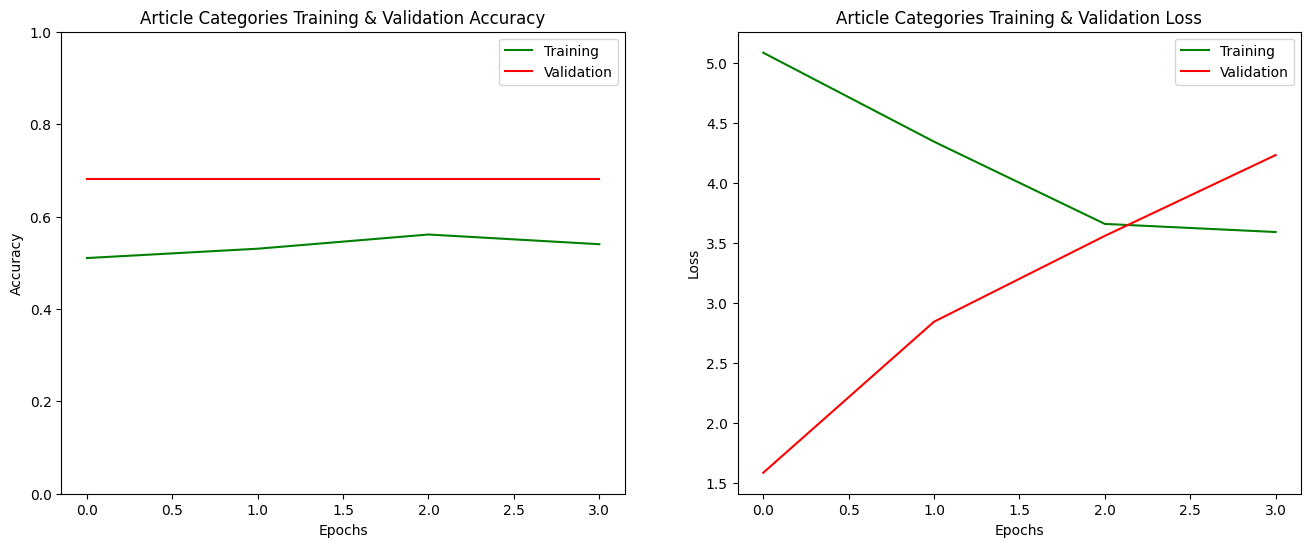

In [46]:
plot_training_results(large_model_categories, 'Article Categories Training & Validation Accuracy', 'Article Categories Training & Validation Loss')

In [47]:
category_prob = []
predicted_category = []
#initiate a loop to store all of the test data into a list, and then into a dataframe
i = 0
for i in range(len(large_test_content)):
  #this takes the raw probabilities and obtains the most likely emotion given those probabilities
  p = large_article_model_categories.predict(np.expand_dims(padded_test_seq_large[i], axis=0))[0]
  #this outputs the raw probabilities for each emotion given the text
  raw_probabilities = large_article_model_categories.predict(np.expand_dims(padded_test_seq_large[i], axis=0))[0]
  predicted_class = np.argmax(p)
  category_prob.append(raw_probabilities.tolist())
  predicted_category.append(predicted_class)
  #sample only the first 20 values for sake of scrolling through code on github
  #can be changed to print all values, just delete the if statement
  if(i < 20):
    print('Article Content: ', large_train_content[i])
    print('Corresponding Categories: 0: Objective, 1: Slightly_Objective, 2: Slightly_Subjective, 3: Subjective')
    print('Raw Probabilities:', raw_probabilities)
    print('Predicted Subjectivity:', predicted_class)
    print('Actual Subjectivity:', grouped_train_labels[i])
  i = i + 1

1/1 [==============================] - 0s 64ms/step
Article Content:  musician tackle red tape musician group tackle visa regulation blamed hindering british act chance succeeding atlantic singer hoping perform expect pay simply obtaining visa group including musician union calling raw faced british performer act faced comparable expense bureaucracy visiting promotional purpose nigel mccune musician union british musician disadvantaged compared counterpart sponsor petition behalf form amounting nearly page musician face tougher regulation athlete journalist mistake form risk ban ability career say mr mccune biggest music market mean creaky bureaucracy say mr mccune current situation preventing british act maintaining momentum developing added musician union stance endorsed music manager forum mmf british artist face uphill struggle succeed thanks tough visa requirement seen impractical mmf secretary james seller imagine orchestra orkneys member travel london visa processed market seen 

In [48]:
#confusion matrix for subjectivity model
"""category_names = ['Objective', 'Slightly_Objective', 'Slightly_Subjective', 'Subjective']
def display_confusion_matrix(true_labels, predicted_labels, class_names, title):
    #compute and normalize the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

    #create a figure with a specified size
    plt.figure(figsize=(6, 6))

    #display the confusion matrix as a matrix plot
    plt.matshow(cm)

    #set x-axis and y-axis tick positions and labels
    plt.xticks(np.arange(len(category_names)), labels=category_names)
    plt.yticks(np.arange(len(category_names)), labels=category_names)

    #display a colorbar to indicate the scale
    plt.colorbar()
    #title
    plt.title(title)
    plt.show()

display_confusion_matrix(grouped_test_labels, predicted_category, class_names, "Large Validation Confusion Matrix")"""

'category_names = [\'Objective\', \'Slightly_Objective\', \'Slightly_Subjective\', \'Subjective\']\ndef display_confusion_matrix(true_labels, predicted_labels, class_names, title):\n    #compute and normalize the confusion matrix\n    cm = confusion_matrix(true_labels, predicted_labels, normalize=\'true\')\n\n    #create a figure with a specified size\n    plt.figure(figsize=(6, 6))\n\n    #display the confusion matrix as a matrix plot\n    plt.matshow(cm)\n\n    #set x-axis and y-axis tick positions and labels\n    plt.xticks(np.arange(len(category_names)), labels=category_names)\n    plt.yticks(np.arange(len(category_names)), labels=category_names)\n\n    #display a colorbar to indicate the scale\n    plt.colorbar()\n    #title\n    plt.title(title)\n    plt.show()\n\ndisplay_confusion_matrix(grouped_test_labels, predicted_category, class_names, "Large Validation Confusion Matrix")'